<a href="https://colab.research.google.com/github/Juba-Amr/breast-cancer-CNN/blob/main/notebooks/colab_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#imports
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve

In [10]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
#paths
ds_path = '/kaggle/input/idc-histology-cleaned-and-splitted'

train_path= '/kaggle/input/idc-histology-cleaned-and-splitted/train'
val_path= '/kaggle/input/idc-histology-cleaned-and-splitted/validation'
test_path= '/kaggle/input/idc-histology-cleaned-and-splitted/test'

Same preprocessing as before

In [ ]:
#for reproducability
def set_seed(seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

X_train = image_dataset_from_directory(
    train_path,
    labels='inferred',
    label_mode='binary',
    color_mode='rgb',
    batch_size=None,
    image_size=(50,50),
    shuffle=True,
    interpolation='nearest'
)

X_val = image_dataset_from_directory(
    val_path,
    labels='inferred',
    label_mode='binary',
    color_mode='rgb',
    batch_size=None,
    image_size=(50,50),
    shuffle=True,
    interpolation='nearest'
)

Found 193299 files belonging to 2 classes.


I0000 00:00:1752358281.510962     195 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 38496 files belonging to 2 classes.


In [5]:
#preprocessing
AUTOTUNE = tf.data.experimental.AUTOTUNE
def preprocess(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32) 
    return image, label

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip(mode='horizontal_and_vertical'),
    layers.RandomRotation(factor=(-0.3, 0.3)),
]) 

def augmentation(image, label):
    return (data_augmentation(image), label)

In [ ]:
print(tf.data.experimental.cardinality(X_train).numpy())
print(tf.data.experimental.cardinality(X_val).numpy())

X_train = (
    X_train
    .map(preprocess, num_parallel_calls=AUTOTUNE, deterministic=True)
    .map(augmentation , num_parallel_calls=AUTOTUNE, deterministic=True)
    .shuffle(buffer_size=1000)
    .batch(16)#here we're using some smaller batches 
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
X_val = (
    X_val
    .map(preprocess, num_parallel_calls=AUTOTUNE, deterministic=True)
    .batch(16)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

print(tf.data.experimental.cardinality(X_train).numpy())
print(tf.data.experimental.cardinality(X_val).numpy())


193299
38496
12082
2406


In [ ]:
feature_extraction = [
        layers.Conv2D(filters=32, kernel_size=(3,3), strides=1, padding='same', use_bias=False), 
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPool2D(pool_size=(2,2), strides=None, padding='valid'), 

        layers.Conv2D(filters=64, kernel_size=(3,3), use_bias=False), 
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPool2D(pool_size=(2,2), strides=None, padding='valid'), 

        layers.Conv2D(filters=128, kernel_size=(3,3), use_bias=False), 
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPool2D(pool_size=(2,2), strides=None, padding='valid'), 

        layers.GlobalAveragePooling2D()
    ]

model_body = [
        layers.Dense(units=64, input_shape=[4608], kernel_regularizer='l2'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.5),

        layers.Dense(units=64, kernel_regularizer='l2'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.5),

        layers.Dense(units=64, kernel_regularizer='l2'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.5),

        layers.Dense(units=1, activation='sigmoid')
    ]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [18]:
model = tf.keras.Sequential([
    *feature_extraction,
    *model_body
])

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryFocalCrossentropy(gamma=2.0, from_logits=False),
    metrics=['binary_accuracy',
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.AUC(name='auc')
        ]
)


early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor= "val_loss",
    min_delta= 0.001,
    patience= 5,
    mode='min',
    restore_best_weights=True,
    start_from_epoch=10
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "/kaggle/working/model/checkpoints/{epoch:02d}-{val_loss:.2f}.keras",
    monitor='val_loss',
    verbose=1,
    save_best_only=False,
    save_weights_only=False,
    save_freq='epoch'
)

reduce_lr =tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1
)

In [25]:
history = model.fit(
    X_train,
    epochs=60,
    verbose=1,
    callbacks=[early_stopping, checkpoint, reduce_lr],
    validation_split=0,
    validation_data=X_val,
    validation_steps=None,
    class_weight={0:1.0, 1:4.2},
    validation_freq=1
)

model.save("../model/model4/model.keras")

Epoch 1/60
12082/12082 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - auc: 0.8288 - binary_accuracy: 0.7235 - loss: 0.6608 - precision: 0.5027 - recall: 0.8334
Epoch 1: saving model to ../model/model4/checkpoints/01-0.14.keras
12082/12082 ━━━━━━━━━━━━━━━━━━━━ 580s 47ms/step - auc: 0.8288 - binary_accuracy: 0.7235 - loss: 0.6608 - precision: 0.5027 - recall: 0.8334 - val_auc: 0.8898 - val_binary_accuracy: 0.8248 - val_loss: 0.1412 - val_precision: 0.7581 - val_recall: 0.6707 - learning_rate: 0.0010
Epoch 2/60
12079/12082 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.8928 - binary_accuracy: 0.7852 - loss: 0.2227 - precision: 0.5724 - recall: 0.8810
Epoch 2: saving model to ../model/model4/checkpoints/02-0.14.keras
12082/12082 ━━━━━━━━━━━━━━━━━━━━ 249s 17ms/step - auc: 0.8928 - binary_accuracy: 0.7852 - loss: 0.2227 - precision: 0.5724 - recall: 0.8810 - val_auc: 0.8833 - val_binary_accuracy: 0.8063 - val_loss: 0.1387 - val_precision: 0.6580 - val_recall: 0.8313 - learning_rate: 0.0010
Epoch 3/60
12079

Due to collab crashing, the model training stopped, but we can resume it on Kaggle from epoch 21 where it ended

In [20]:
model= tf.keras.models.load_model('/kaggle/input/cnn_model_bc/keras/default/1/model.keras')

history = model.fit(
    X_train,
    epochs=60,
    verbose=1,
    callbacks=[early_stopping, checkpoint, reduce_lr],
    initial_epoch=21,
    validation_split=0,
    validation_data=X_val,
    validation_steps=None,
    class_weight={0:1.0, 1:4.2},
    validation_freq=1
)

model.save('/kaggle/working/model/model_v5.keras')

Epoch 22/60


2025-07-12 22:44:55.371271: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_5}}


12079/12082 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9167 - binary_accuracy: 0.8173 - loss: 0.1953 - precision: 0.6163 - recall: 0.8984
Epoch 22: saving model to /kaggle/working/model/checkpoints/22-0.12.keras
12082/12082 ━━━━━━━━━━━━━━━━━━━━ 141s 11ms/step - auc: 0.9167 - binary_accuracy: 0.8173 - loss: 0.1953 - precision: 0.6163 - recall: 0.8984 - val_auc: 0.9051 - val_binary_accuracy: 0.8402 - val_loss: 0.1202 - val_precision: 0.7396 - val_recall: 0.7786 - learning_rate: 0.0010
Epoch 23/60
12081/12082 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9126 - binary_accuracy: 0.8070 - loss: 0.2028 - precision: 0.6009 - recall: 0.8988
Epoch 23: saving model to /kaggle/working/model/checkpoints/23-0.16.keras
12082/12082 ━━━━━━━━━━━━━━━━━━━━ 134s 11ms/step - auc: 0.9126 - binary_accuracy: 0.8070 - loss: 0.2028 - precision: 0.6009 - recall: 0.8988 - val_auc: 0.8709 - val_binary_accuracy: 0.7754 - val_loss: 0.1575 - val_precision: 0.8451 - val_recall: 0.3714 - learning_rate: 0.0010
Epoch 24/60


<Axes: >

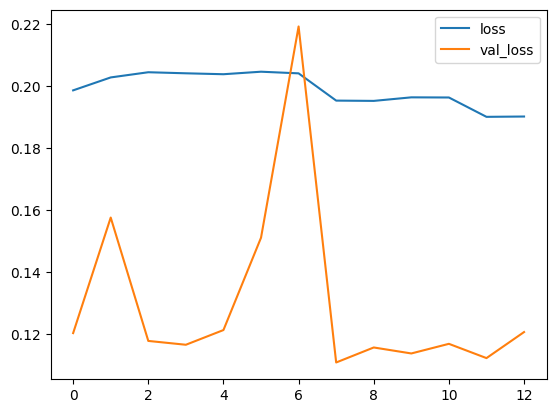

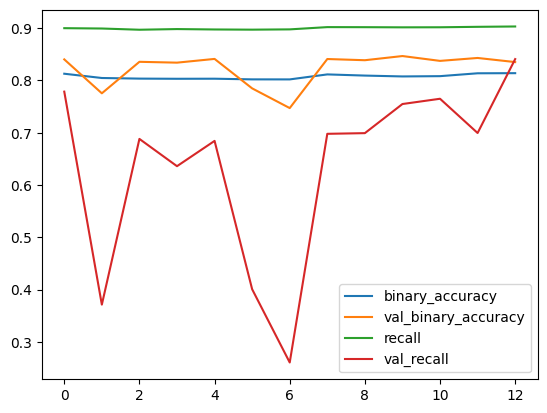

In [21]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy', 'recall', 'val_recall']].plot()

pretty good results! let's evaluate on testing set

In [6]:
X_test = image_dataset_from_directory(
    test_path,
    labels='inferred',
    label_mode='binary',
    color_mode='rgb',
    batch_size=None,
    image_size=(50,50),
    shuffle=True,
    interpolation='nearest'
)
X_test = (
    X_test
    .map(preprocess, num_parallel_calls=AUTOTUNE, deterministic=True)
    .batch(16)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

Found 45729 files belonging to 2 classes.


In [7]:
model = tf.keras.models.load_model('../model/model3/model_v5.keras')

In [8]:
model.evaluate(
    X_test,
    batch_size=None,
    verbose=1,
    steps=None,
    return_dict=True
)

2859/2859 ━━━━━━━━━━━━━━━━━━━━ 89s 31ms/step - auc: 0.9026 - binary_accuracy: 0.8406 - loss: 0.1080 - precision: 0.6987 - recall: 0.7772


{'auc': 0.9044559001922607,
 'binary_accuracy': 0.8445625305175781,
 'loss': 0.1068098247051239,
 'precision': 0.7008564472198486,
 'recall': 0.7851284146308899}

I am more than happy with these results, the model learned to generalize very well, AUC shows an excellent ability to distinguish between positive and negative classes, 84.4% accuracy is very good for this imbalanced data, precision is okay and most importantly we have 78.5% of Recall which is very good, we will rarely have a false negative while keeping a reasonable false positives rate.

let's see this more clearly on a confusion matrix.

But scikit-learn's classification metrics can't handle a mix of binary and continuous targets so we need to find a good threshold to binarize our predictions and we'll use the recall and precision curve and then look for the best f1 score, and ROC curve so we can compare both.

In [9]:
y_pred = model.predict(X_test)
y_true = np.concatenate([labels for _,labels in X_test])

2859/2859 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step


ROC curve method

In [10]:
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
j_scores = tpr - fpr
best_threshold_roc = thresholds[np.argmax(j_scores)]
print(f"Best threshold by ROC Youden's J: {best_threshold_roc}")

Best threshold by ROC Youden's J: 0.4114065170288086


best f1 score calculator

In [11]:
f1_scores = []
thresholds = np.linspace(0.4,0.6,1000)

for t in thresholds:
    preds = (y_pred >= t).astype(int)
    f1 = f1_score(y_true, preds)
    f1_scores.append(f1)

best_threshold = thresholds[np.argmax(f1_scores)]
print(f"Best threshold by F1 score: {best_threshold}")

Best threshold by F1 score: 0.48848848848848847


And we can see both these thresholds on a recall, precision curve

In [28]:
y_true = []
y_score = []

for images, labels in X_test:
    probs = model.predict(images, verbose=0)
    y_score.extend(probs.flatten())       # predicted probabilities
    y_true.extend(labels.numpy().flatten())  # true labels

y_true = np.array(y_true)
y_score = np.array(y_score)

precision, recall, thresholds = precision_recall_curve(y_true, y_score)

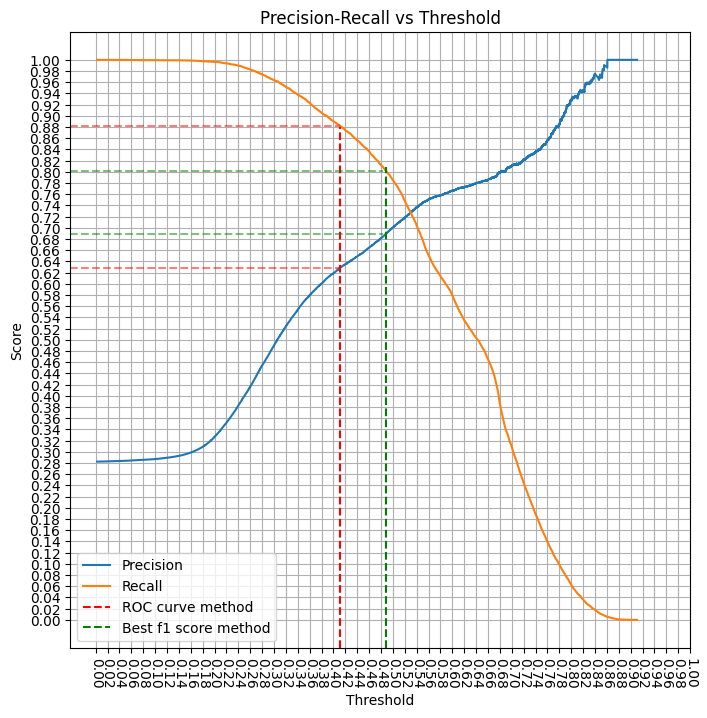

In [76]:
plt.figure(figsize=(8,8))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.axvline(x=0.4114,ymin=0,ymax=0.845, color='red', linestyle='--', label='ROC curve method')
plt.axvline(x=0.4885, ymin=0, ymax=0.78 ,color='green', linestyle='--', label='Best f1 score method')

idx_roc = np.abs(thresholds - 0.4114).argmin()
idx_f1 = np.abs(thresholds - 0.4885).argmin()

prec_roc = precision[idx_roc]
rec_roc = recall[idx_roc]
prec_f1 = precision[idx_f1]
rec_f1 = recall[idx_f1]

plt.axhline(y=prec_roc, color='red', linestyle='--', alpha=0.5, xmin=0, xmax=0.435)
plt.axhline(y=rec_roc, color='red', linestyle='--', alpha=0.5, xmin=0, xmax=0.435)
plt.axhline(y=prec_f1, color='green', linestyle='--', alpha=0.5, xmin=0, xmax=0.505)
plt.axhline(y=rec_f1, color='green', linestyle='--', alpha=0.5, xmin=0, xmax=0.505)

plt.xticks(np.linspace(0,1,51), rotation=-90)
plt.yticks(np.linspace(0,1,51))
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall vs Threshold')
plt.legend()
plt.grid(True)
plt.show()

In [47]:
def plot_confusion(X_test, threshold):
    y_pred = model.predict(X_test)
    y_true = np.concatenate([labels for _,labels in X_test])
    
    def binarize(y):
        if y>=threshold:
            return 1
        else:
            return 0
    
    y_pred = [binarize(y) for y in y_pred]
    mat = confusion_matrix(
        y_true=y_true,
        y_pred=y_pred
    )
    return mat

In [85]:
print(f"confusion matrix with 0.4114 is \n{plot_confusion(X_test,0.4114)}")
print(f"confusion matrix with 0.4885 is \n{plot_confusion(X_test,0.4885)}")

2859/2859 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
confusion matrix with 0.4114 is 
[[26079  6726]
 [ 1519 11405]]
2859/2859 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
confusion matrix with 0.4885 is 
[[28147  4658]
 [ 2559 10365]]


We get slightly different results, using the folowing formulas we can compute all the metrics
 
$$\text{Precision} = \frac{TP}{TP + FP}$$

$$\text{Recall} = \frac{TP}{TP + FN}$$

$$\text{F1} = \frac{2TP}{2TP + FP + FN}$$
$$\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}$$

In [86]:
data = {
    'Threshold': ['0.4114 (ROC-Youden)', '0.4885 (F1-optimal)'],
    'Precision': [0.6288, 0.6901],
    'Recall': [0.8824, 0.8021],
    'F1 Score': [0.7344, 0.7419],
    'Accuracy': [0.819, 0.8433],
    'False Positives': [6726, 4658],
    'False Negatives': [1519, 2559]
}

df = pd.DataFrame(data)
df.set_index('Threshold', inplace=True)
display(df)

,Precision,Recall,F1 Score,Accuracy,False Positives,False Negatives
Threshold,,,,,,
0.4114 (ROC-Youden),0.6288,0.8824,0.7344,0.8190,6726,1519
0.4885 (F1-optimal),0.6901,0.8021,0.7419,0.8433,4658,2559


**Interpretation:**

The ROC-based threshold (0.4114) achieves higher recall, which is desirable in medical contexts where missing a positive case is dangerous.

The F1-optimal threshold (0.4885) offers a better balance of precision and recall, leading to a higher F1 score and accuracy overall.

False positives are significantly reduced with the F1-optimal threshold, making predictions more trustworthy in real-world settings.

We chose to favor the F1-optimal threshold as it maintains strong recall while improving precision and reducing false alarms, offering a robust trade-off for practical deployment.

---

## Conclusion

This project successfully demonstrates the design and training of a custom CNN to classify Invasive Ductal Carcinoma (IDC) from breast histopathology images, achieving strong performance metrics including an AUC of 0.90 and balanced precision and recall. The model provides a solid foundation for further exploration and potential clinical application.

## Next Steps

- Implement Grad-CAM visualizations for model explainability  
- Experiment with more advanced CNN architectures (e.g., EfficientNet)  
- Develop a user-friendly interface or deploy the model as a web app  

---

*Thank you for reviewing my work! Feel free to reach out for questions, feedback, or collaboration.*

